COVID-19 Data Analysis using Confirmed & Deaths Datasets

Step 1: Import Libraries

In [2]:
# Cell 1 — Imports & plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Load Datasets

In [3]:
# Cell 2 — Load CSVs
confirmed = pd.read_csv('covid19_Confirmed_dataset.csv')
deaths = pd.read_csv('covid19_deaths_dataset.csv')
happiness = pd.read_csv('worldwide_happiness_report.csv')

In [4]:
# Quick shapes & columns check

In [5]:
confirmed.shape

(266, 104)

In [6]:
deaths.shape

(266, 104)

In [7]:
happiness.shape

(156, 9)

checking null values

In [7]:
confirmed.isna().sum()

Province/State    184
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
4/26/20             0
4/27/20             0
4/28/20             0
4/29/20             0
4/30/20             0
Length: 104, dtype: int64

In [8]:
deaths.isna().sum()

Province/State    184
Country/Region      0
Lat                 0
Long                0
1/22/20             0
                 ... 
4/26/20             0
4/27/20             0
4/28/20             0
4/29/20             0
4/30/20             0
Length: 104, dtype: int64

In [10]:
happiness.isna().sum()

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

Step 3:find last date column automatically

In [12]:
# Cell 3 — find last date column automatically
last_date_confirmed = confirmed.columns[-1]   # last column is (e.g.) '4/30/20'
last_date_deaths = deaths.columns[-1]
print("Last date confirmed:", last_date_confirmed)
print("Last date deaths   :", last_date_deaths)



Last date confirmed: 4/30/20
Last date deaths   : 4/30/20


Step 4:  aggregate confirmed and deaths by Country/Region (take last date column)

In [13]:
# Cell 4 — aggregate confirmed and deaths by Country/Region (take last date column)
conf_agg = confirmed.groupby('Country/Region')[last_date_confirmed].sum().reset_index()
conf_agg.rename(columns={last_date_confirmed: 'TotalConfirmed', 'Country/Region': 'Country'}, inplace=True)

deaths_agg = deaths.groupby('Country/Region')[last_date_deaths].sum().reset_index()
deaths_agg.rename(columns={last_date_deaths: 'TotalDeaths', 'Country/Region': 'Country'}, inplace=True)

# Ensure numeric and fill NA
conf_agg['TotalConfirmed'] = conf_agg['TotalConfirmed'].fillna(0).astype(int)
deaths_agg['TotalDeaths'] = deaths_agg['TotalDeaths'].fillna(0).astype(int)

# Quick peek
conf_agg.head()



,Country,TotalConfirmed
0,Afghanistan,2171
1,Albania,773
2,Algeria,4006
3,Andorra,745
4,Angola,27


Step 5: detect important columns in happiness file (robust to slight column name differences)

In [14]:
# Cell 5 — detect important columns in happiness file (robust to slight column name differences)
def find_col(df, keywords):
    for k in keywords:
        for c in df.columns:
            if k.lower() in c.lower():
                return c
    return None

country_col = find_col(happiness, ['country'])
score_col = find_col(happiness, ['score','happiness'])
gdp_col = find_col(happiness, ['gdp'])
social_col = find_col(happiness, ['social'])
life_col = find_col(happiness, ['life','healthy'])
freedom_col = find_col(happiness, ['freedom'])
generosity_col = find_col(happiness, ['generosity'])
corruption_col = find_col(happiness, ['corrupt'])

print("Detected columns:")
print("country:", country_col)
print("score  :", score_col)
print("gdp    :", gdp_col)
print("social :", social_col)
print("life   :", life_col)
print("freedom:", freedom_col)
print("generos:", generosity_col)
print("corrupt:", corruption_col)

# Subset and rename
happy_sub = happiness[[country_col, score_col, gdp_col, social_col, life_col, freedom_col, generosity_col, corruption_col]].copy()
happy_sub.columns = ['Country', 'HappinessScore', 'GDP', 'SocialSupport', 'LifeExpectancy', 'Freedom', 'Generosity', 'Corruption']

# Convert numeric columns to numeric dtype if needed
num_cols = ['HappinessScore','GDP','SocialSupport','LifeExpectancy','Freedom','Generosity','Corruption']
for c in num_cols:
    happy_sub[c] = pd.to_numeric(happy_sub[c], errors='coerce')

happy_sub.head()


Detected columns:
country: Country or region
score  : Score
gdp    : GDP per capita
social : Social support
life   : Healthy life expectancy
freedom: Freedom to make life choices
generos: Generosity
corrupt: Perceptions of corruption


,Country,HappinessScore,GDP,SocialSupport,LifeExpectancy,Freedom,Generosity,Corruption
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Step 6:  strip whitespace and standardize case (basic cleaning)

In [15]:
# Cell 6 — strip whitespace and standardize case (basic cleaning)
conf_agg['Country'] = conf_agg['Country'].str.strip()
deaths_agg['Country'] = deaths_agg['Country'].str.strip()
happy_sub['Country'] = happy_sub['Country'].str.strip()

# Merge confirmed + deaths into one covid_totals DataFrame
covid_totals = pd.merge(conf_agg, deaths_agg[['Country','TotalDeaths']], on='Country', how='left')
covid_totals['TotalDeaths'] = covid_totals['TotalDeaths'].fillna(0).astype(int)
covid_totals.head()


,Country,TotalConfirmed,TotalDeaths
0,Afghanistan,2171,64
1,Albania,773,31
2,Algeria,4006,450
3,Andorra,745,42
4,Angola,27,2


Step 7: check unmatched countries before merging with happiness

In [16]:
# Cell 7 — check unmatched countries before merging with happiness
set_covid = set(covid_totals['Country'].unique())
set_happy = set(happy_sub['Country'].unique())

missing_in_happiness = sorted(list(set_covid - set_happy))
missing_in_covid = sorted(list(set_happy - set_covid))

print("Countries present in COVID but NOT in Happiness (sample 20):", missing_in_happiness[:20])
print("Countries present in Happiness but NOT in COVID (sample 20):", missing_in_covid[:20])

# If many mismatches, you can create a manual mapping dict to reconcile names (example below):
# name_map = {'US':'United States', 'Korea, South':'South Korea', 'Czechia':'Czech Republic', ...}
# covid_totals['Country'] = covid_totals['Country'].replace(name_map)
# happy_sub['Country'] = happy_sub['Country'].replace(name_map)



Countries present in COVID but NOT in Happiness (sample 20): ['Andorra', 'Angola', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Brunei', 'Burma', 'Cabo Verde', "Cote d'Ivoire", 'Cuba', 'Czechia', 'Diamond Princess', 'Djibouti', 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Fiji', 'Grenada']
Countries present in Happiness but NOT in COVID (sample 20): ['Czech Republic', 'Hong Kong', 'Ivory Coast', 'Lesotho', 'Myanmar', 'Northern Cyprus', 'Palestinian Territories', 'South Korea', 'Swaziland', 'Taiwan', 'Trinidad & Tobago', 'Turkmenistan', 'United States']


Step 8: merge

In [17]:
# Cell 8 — merge (inner join so we analyze only countries present in both)
merged = pd.merge(covid_totals, happy_sub, on='Country', how='inner')

# Basic cleaning: drop rows with no happiness score
merged = merged.dropna(subset=['HappinessScore']).reset_index(drop=True)
print("Merged shape:", merged.shape)
merged.head()



Merged shape: (143, 10)


,Country,TotalConfirmed,TotalDeaths,HappinessScore,GDP,SocialSupport,LifeExpectancy,Freedom,Generosity,Corruption
0,Afghanistan,2171,64,3.203,0.350,0.517,0.361,0.000,0.158,0.025
1,Albania,773,31,4.719,0.947,0.848,0.874,0.383,0.178,0.027
2,Algeria,4006,450,5.211,1.002,1.160,0.785,0.086,0.073,0.114
3,Argentina,4428,218,6.086,1.092,1.432,0.881,0.471,0.066,0.050
4,Armenia,2066,32,4.559,0.850,1.055,0.815,0.283,0.095,0.064


Step 9:  compute Mortality Rate safely

In [18]:
# Cell 9 — compute Mortality Rate safely
merged['MortalityRate'] = np.where(merged['TotalConfirmed'] > 0,
                                   merged['TotalDeaths'] / merged['TotalConfirmed'] * 100,
                                   0.0)

# Optional: log transformed measures (helpful for plotting)
merged['LogConfirmed'] = np.log1p(merged['TotalConfirmed'])
merged['LogDeaths'] = np.log1p(merged['TotalDeaths'])

merged[['Country','TotalConfirmed','TotalDeaths','MortalityRate','HappinessScore','GDP']].head()



,Country,TotalConfirmed,TotalDeaths,MortalityRate,HappinessScore,GDP
0,Afghanistan,2171,64,2.947950,3.203,0.350
1,Albania,773,31,4.010349,4.719,0.947
2,Algeria,4006,450,11.233150,5.211,1.002
3,Argentina,4428,218,4.923216,6.086,1.092
4,Armenia,2066,32,1.548887,4.559,0.850


Step 10: correlation matrix for selected columns

In [19]:
# Cell 10 — correlation matrix for selected columns
corr_cols = ['HappinessScore','GDP','SocialSupport','LifeExpectancy','Freedom','Generosity','Corruption','TotalConfirmed','TotalDeaths','MortalityRate']
corr_df = merged[corr_cols].corr()
corr_df.round(3)
# Print correlation of features with MortalityRate (sorted)
print("Correlation with MortalityRate:")
print(corr_df['MortalityRate'].sort_values(ascending=False).round(3))



Correlation with MortalityRate:
MortalityRate     1.000
TotalDeaths       0.414
TotalConfirmed    0.313
Corruption        0.061
SocialSupport     0.029
LifeExpectancy    0.023
HappinessScore    0.006
Generosity       -0.046
GDP              -0.053
Freedom          -0.183
Name: MortalityRate, dtype: float64


step 11 — Top 10 countries by Total Confirmed (bar)

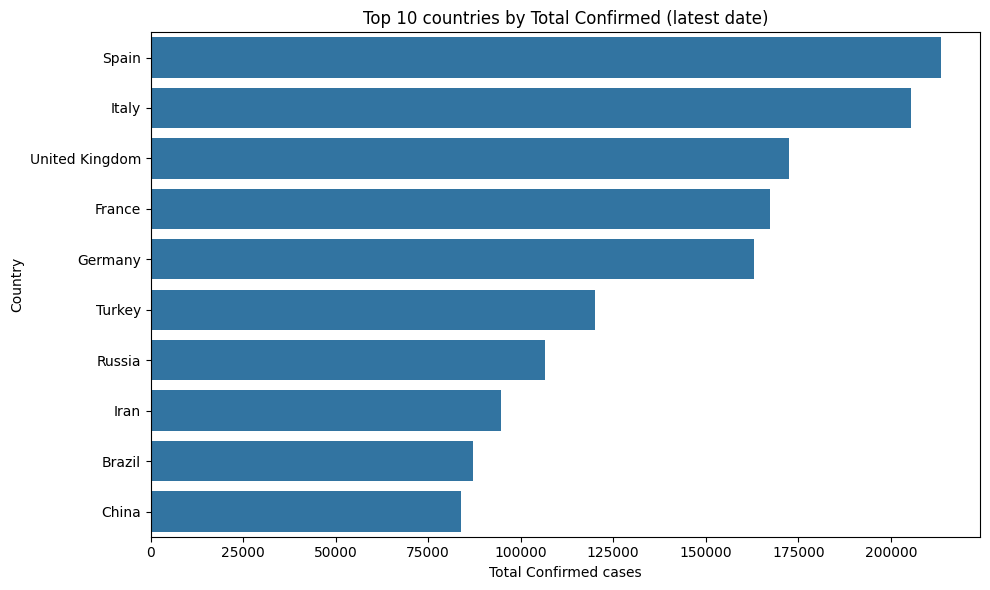

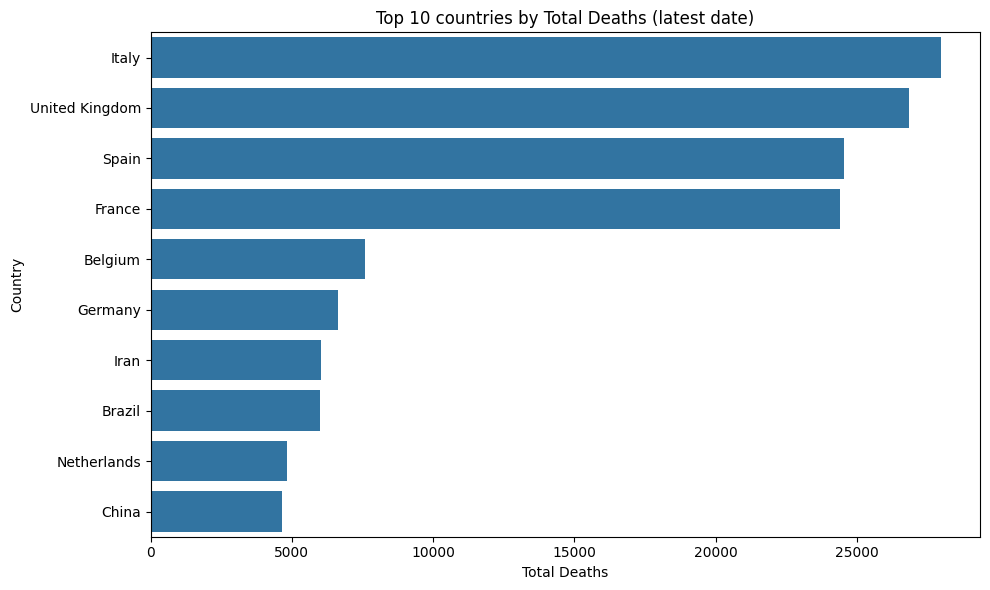

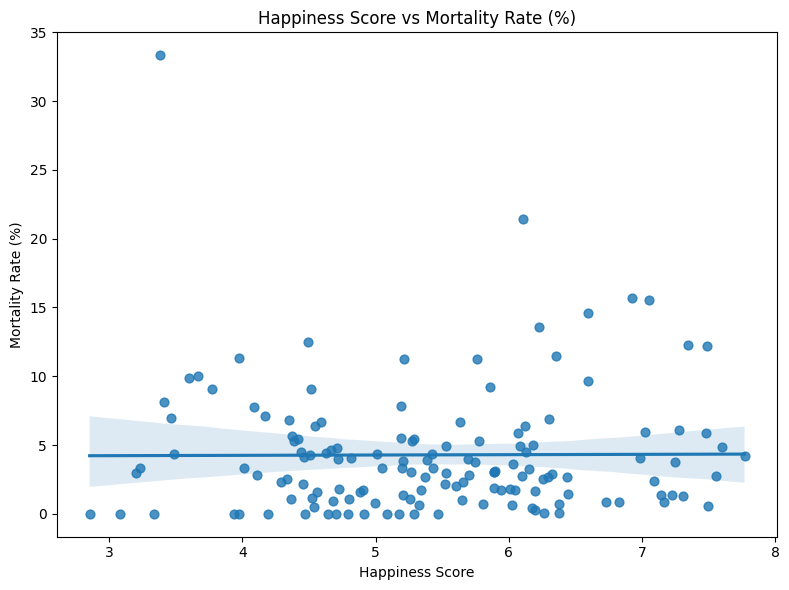

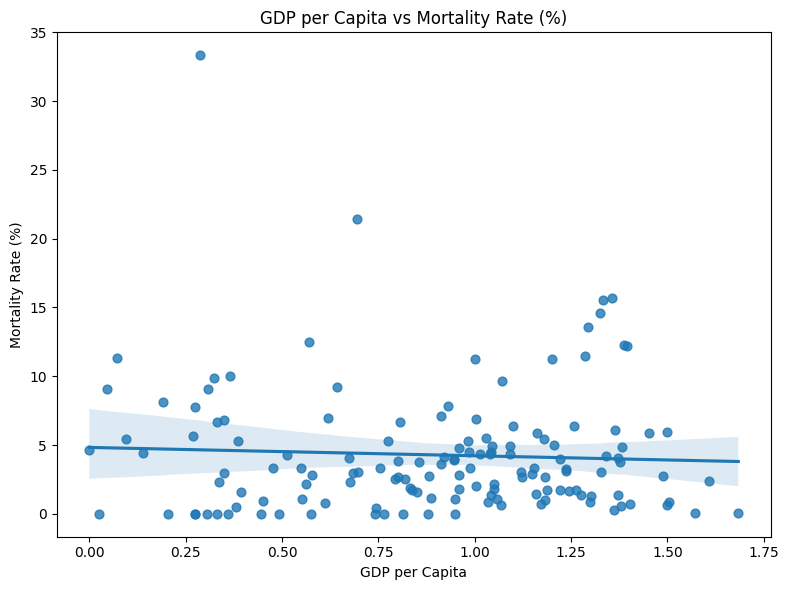

In [20]:
# Cell 11a — Top 10 countries by Total Confirmed (bar)
top10_confirmed = merged.sort_values('TotalConfirmed', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top10_confirmed, x='TotalConfirmed', y='Country')
plt.title('Top 10 countries by Total Confirmed (latest date)')
plt.xlabel('Total Confirmed cases')
plt.tight_layout()
plt.show()

# Cell 11b — Top 10 countries by Total Deaths (bar)
top10_deaths = merged.sort_values('TotalDeaths', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top10_deaths, x='TotalDeaths', y='Country')
plt.title('Top 10 countries by Total Deaths (latest date)')
plt.xlabel('Total Deaths')
plt.tight_layout()
plt.show()

# Cell 11c — Scatter: HappinessScore vs MortalityRate (with regression line)
plt.figure(figsize=(8,6))
sns.regplot(data=merged, x='HappinessScore', y='MortalityRate', scatter_kws={'s':40})
plt.title('Happiness Score vs Mortality Rate (%)')
plt.xlabel('Happiness Score')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()

# Cell 11d — Scatter: GDP vs MortalityRate
plt.figure(figsize=(8,6))
sns.regplot(data=merged, x='GDP', y='MortalityRate', scatter_kws={'s':40})
plt.title('GDP per Capita vs Mortality Rate (%)')
plt.xlabel('GDP per Capita')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()


In [21]:
# Cell 12 — show strongest positive/negative correlations with MortalityRate
corr_with_mort = corr_df['MortalityRate'].dropna().sort_values()
print("Top negative correlations with MortalityRate (possible protective factors):")
print(corr_with_mort.head(5).round(3))
print("\nTop positive correlations with MortalityRate:")
print(corr_with_mort.tail(5).round(3))

# Example of extracting a few quick insights automatically:
insights = []
if corr_df.loc['HappinessScore','MortalityRate'] < 0:
    insights.append("HappinessScore is negatively correlated with MortalityRate (higher happiness → lower mortality).")
else:
    insights.append("HappinessScore is positively correlated with MortalityRate (interpret with caution).")

insights.append(f"Highest correlation with MortalityRate: {corr_df['MortalityRate'].abs().idxmax()} ({corr_df['MortalityRate'].abs().max():.3f})")
for s in insights:
    print("-", s)


Top negative correlations with MortalityRate (possible protective factors):
Freedom          -0.183
GDP              -0.053
Generosity       -0.046
HappinessScore    0.006
LifeExpectancy    0.023
Name: MortalityRate, dtype: float64

Top positive correlations with MortalityRate:
SocialSupport     0.029
Corruption        0.061
TotalConfirmed    0.313
TotalDeaths       0.414
MortalityRate     1.000
Name: MortalityRate, dtype: float64
- HappinessScore is positively correlated with MortalityRate (interpret with caution).
- Highest correlation with MortalityRate: MortalityRate (1.000)


# Conclusions (example)
- Correlation analysis shows (fill with observed results after running): e.g., "HappinessScore has a small negative correlation with mortality rate, suggesting countries with higher happiness generally experienced somewhat lower COVID mortality (subject to confounders)."
- GDP and LifeExpectancy also correlate with COVID outcomes — interpret with caution (population, testing rates, health system capacity, age structure are confounders).
- Next steps: add population data (cases/deaths per 100k), control for age structure, run regression models to control confounders, and reconcile country-name mismatches for more complete coverage.


In [22]:
# Cell 13 — Save merged CSV and a small summary CSV
merged.to_csv('covid_happiness_merged.csv', index=False)
print("Saved merged file: covid_happiness_merged.csv")


Saved merged file: covid_happiness_merged.csv
